In [ ]:
from torch import nn
from torch.optim import Adam
import torch

class CNN(nn.Module):
    def __init__(self, num_actions, input_shape=(96, 96, 3), lr = 1e-5, softmax = True):
        super(CNN, self).__init__()

        self.input_channels = input_shape[-1]
        self.input_size = input_shape[:-1]
        self.num_actions = num_actions
        
        kernel_size = 5
        layers = [
            nn.Conv2d(self.input_channels, 16, bias = False, kernel_size = kernel_size, stride=2, padding = kernel_size//2),
            nn.LeakyReLU(0.01),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, kernel_size = kernel_size, bias = False, stride=1, padding = kernel_size//2),
            nn.LeakyReLU(0.01),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, kernel_size = kernel_size, bias = False, stride=2, padding = kernel_size//2),
            nn.LeakyReLU(0.01),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, kernel_size = kernel_size, bias = False, stride=1, padding = kernel_size//2),
            nn.LeakyReLU(0.01),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, kernel_size = kernel_size, bias = False, stride=2, padding = kernel_size//2),
            nn.LeakyReLU(0.01),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, kernel_size = kernel_size, bias = False, stride=1, padding = kernel_size//2),
            nn.LeakyReLU(0.01),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, kernel_size = kernel_size, bias = False, stride=2, padding = kernel_size//2),
            nn.LeakyReLU(0.01),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, kernel_size = kernel_size, bias = False, stride=1, padding = kernel_size//2),
            nn.LeakyReLU(0.01),
            nn.BatchNorm2d(16),
            nn.Flatten(),
            nn.Linear(16 * (self.input_size[0] // 2**4) * (self.input_size[1] // 2**4), 16),
            nn.LeakyReLU(0.01),
            nn.Linear(16, num_actions)]
        
        if self.softmax:
            layers.append(nn.Softmax(dim = -1))
        self.q = nn.Sequential(*layers)

        self.optim = Adam(self.parameters(), lr=lr)

    def forward(self, x):
        x = x.permute(0, 3, 1, 2).float()
        return self.q(x)

In [2]:
from torchsummary import summary
model = CNN(3)
print(model)
summary(model, (96, 96, 3), device="cpu")

CNN(
  (q): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(16, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (7): LeakyReLU(negative_slope=0.01)
    (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (10): LeakyReLU(negative_slope=0.01)
    (11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(16, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (13): LeakyReLU(neg

In [8]:
from copy import deepcopy
import numpy as np
import time

def train_qlearn(model, env, num_episodes=1000, gamma=0.9, epsilon_decay=0.9):
    import torch
    import torch.nn as nn

    # Use the provided device variable
    global device

    # Create target model (on GPU)
    target_model = deepcopy(model)
    target_model.load_state_dict(model.state_dict())
    target_model.to(device)
    model.to(device)

    # Create CPU model for env interaction
    cpu_model = deepcopy(model)
    cpu_model.load_state_dict(model.state_dict())
    cpu_model.to("cpu")

    current_index = 0
    buffer_size = 4096
    state_shape = env.observation_space.shape

    # Keep replay buffer on GPU
    states_buffer = torch.zeros((buffer_size, *state_shape), dtype=torch.float32, device=device)
    actions_buffer = torch.zeros((buffer_size,), dtype=torch.int64, device=device)
    rewards_buffer = torch.zeros((buffer_size,), dtype=torch.float32, device=device)
    dones_buffer = torch.zeros((buffer_size,), dtype=torch.bool, device=device)
    rewards_history = []

    epsilon = 1
    try:
        for e in range(num_episodes):
            state, *_ = env.reset()
            state = torch.from_numpy(np.array(state)).float()  # keep on CPU for env
            done = False

            total_reward = 0

            elapsed_time = 0
            total_action_time = 0 
            total_step_time = 0
            total_sample_time = 0
            total_q_time = 0
            total_train_time = 0

            while not done:
                start_time = time.perf_counter()
                # Choose action
                if np.random.rand() < epsilon:
                    action = env.action_space.sample()
                else:
                    with torch.no_grad():
                        states_tensor = state.unsqueeze(0)  # still on CPU
                        q_values = cpu_model(states_tensor)
                        action = torch.argmax(q_values, dim=1).item()

                action_time = time.perf_counter() 
                total_action_time += action_time - start_time

                # Take action
                next_state, reward, terminal, truncated, _ = env.step(action)
                next_state = torch.from_numpy(np.array(next_state)).float()  # keep on CPU
                done = terminal or truncated
                total_reward += reward

                # Store transition in memory (move to GPU)
                index = current_index % buffer_size
                states_buffer[index] = state.to(device)
                actions_buffer[index] = torch.tensor(action, dtype=torch.int64, device=device)
                rewards_buffer[index] = torch.tensor(reward, dtype=torch.float32, device=device)
                dones_buffer[index] = torch.tensor(done, dtype=torch.bool, device=device)
                current_index += 1

                step_time = time.perf_counter()
                total_step_time += step_time - action_time

                # Update state
                state = next_state

                end_time = time.perf_counter()
                elapsed_time += end_time - start_time

            # Append total reward to history
            rewards_history.append(total_reward)

            # Train the model
            if current_index > 1000:
                batch_size = 128
                for i in range(current_index//batch_size):
                    idx = np.random.choice(min(current_index, buffer_size) - 1, batch_size, replace=False)

                    # All buffers are already on GPU
                    states_tensor = states_buffer[idx]
                    actions_tensor = actions_buffer[idx]
                    rewards_tensor = rewards_buffer[idx]
                    next_states_tensor = states_buffer[idx+1]
                    dones_tensor = dones_buffer[idx]

                    sample_time = time.perf_counter()
                    total_sample_time += sample_time - step_time

                    q_values = model(states_tensor).gather(1, actions_tensor.unsqueeze(1)).squeeze(1)
                    next_q_values = target_model(next_states_tensor).max(1)[0]
                    expected_q_values = rewards_tensor + (gamma * next_q_values * (~dones_tensor))

                    q_time = time.perf_counter()
                    total_q_time += q_time - sample_time

                    loss = nn.MSELoss()(q_values.float(), expected_q_values.float())

                    model.optim.zero_grad()
                    loss.backward()
                    model.optim.step()

                    # After each update, copy weights to cpu_model
                    cpu_model.load_state_dict(model.state_dict())

                    train_time = time.perf_counter()
                    total_train_time += train_time - q_time

            # Update target model
            if e % 10 == 0:
                target_model.load_state_dict(model.state_dict())

            epsilon *= epsilon_decay
            if epsilon < 0.01:
                epsilon = 0.01
            print(f"Episode {e+1}/{num_episodes}, Total Reward: {total_reward}, Time Elapsed: {elapsed_time} seconds")
            print(f"Action Time: {total_action_time:.4f}, Step Time: {total_step_time:.4f}, Sample Time: {total_sample_time:.4f}, Q Time: {total_q_time:.4f}, Train Time: {total_train_time:.4f}")

        print("Training completed successfully.")

    except KeyboardInterrupt:
        print("Training interrupted by user.")
        torch.cuda.empty_cache()
        return rewards_history

    torch.cuda.empty_cache()
    return rewards_history


In [ ]:
import gymnasium as gym
env = gym.make("CarRacing-v3", continuous = False)

#model = CNN(env.action_space.shape)
device = "cuda"
model = CNN(5, softmax = False).to(device)

torch.cuda.empty_cache()
rewards = train_qlearn(model, env, num_episodes=1000, gamma=0.9)
torch.cuda.empty_cache()

Episode 1/1000, Total Reward: -62.32876712328852, Time Elapsed: 18.183899499941617 seconds
Action Time: 0.0676, Step Time: 18.1134, Sample Time: 0.0000, Q Time: 0.0000, Train Time: 0.0000
Episode 2/1000, Total Reward: -59.85401459854097, Time Elapsed: 17.774852699483745 seconds
Action Time: 0.4497, Step Time: 17.3227, Sample Time: 37.1800, Q Time: 0.1130, Train Time: 4.9898
Episode 3/1000, Total Reward: -61.53846153846237, Time Elapsed: 20.9022614005371 seconds
Action Time: 1.7448, Step Time: 19.1544, Sample Time: 86.2325, Q Time: 0.1705, Train Time: 7.5853
Episode 4/1000, Total Reward: -57.894736842105985, Time Elapsed: 22.232058299530763 seconds
Action Time: 2.1557, Step Time: 20.0739, Sample Time: 163.6718, Q Time: 0.2327, Train Time: 10.3894
Episode 5/1000, Total Reward: -56.204379562044544, Time Elapsed: 23.171203900536057 seconds
Action Time: 2.9553, Step Time: 20.2135, Sample Time: 251.7969, Q Time: 0.2734, Train Time: 12.8404
Episode 6/1000, Total Reward: -52.000000000000696, T

In [ ]:
def test_qmodel(model):
    env = gym.make("CarRacing-v3", continuous=False, render_mode="human")
    state, *_ = env.reset()
    done = False
    total_reward = 0

    while not done:
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = model(state_tensor)
        action = q_values.to("cpu").argmax().item()

        next_state, reward, terminal, truncated, info = env.step(action)
        done = terminal or truncated
        total_reward += reward
        state = next_state

        time.sleep(0.01) # Adjust sleep time for rendering speed

    env.close()
    return total_reward

(17975296, 62914560)

In [ ]:
from copy import deepcopy
import numpy as np
import time
from collections import deque

def train_reinforce(model, env, num_episodes=1000, gamma=0.9):
    ## Create target model
    target_model = deepcopy(model)
    target_model.load_state_dict(model.state_dict())

    device = next(model.parameters()).device
    target_model.to(device)

    rewards_history = []

    all_actions = list(range(env.action_space.n))
    try:
        for e in range(num_episodes):
            #buffer_size = 1024
            #replay_buffer = deque(maxlen=buffer_size)
            replay_buffer = []

            state, *_ = env.reset()
            done = False

            total_reward = 0

            elapsed_time = 0
            total_action_time = 0 
            total_step_time = 0
            total_sample_time = 0
            total_q_time = 0
            total_train_time = 0

            #for t in range(buffer_size):
            while True:
                start_time = time.perf_counter()
                # Choose action
                with torch.no_grad():
                    state_tensor = torch.from_numpy(state).unsqueeze(0).to(device)
                    action_dist = model(state_tensor)
                    action_dist = action_dist.squeeze(0).cpu().numpy()
                    action = np.random.choice(all_actions, p=action_dist)

                action_time = time.perf_counter() 
                total_action_time += action_time - start_time

                # Take action
                next_state, reward, terminal, truncated, _ = env.step(action)
                total_reward += reward

                replay_buffer.append([state, action, reward])

                step_time = time.perf_counter()
                total_step_time += step_time - action_time

                # Update state
                state = next_state
                done = terminal or truncated
                if done:
                    break

            running_rewards = 0
            for i in range(len(replay_buffer)):
                r = replay_buffer[-i-1][2]
                running_rewards = r + gamma * running_rewards
                replay_buffer[-i-1][2] = running_rewards

            sample_time = time.perf_counter()
            total_sample_time += sample_time - step_time
            
            states_tensor = torch.tensor([t[0] for t in replay_buffer], dtype=torch.float32, device=device)
            preds = model(states_tensor)
            
            q_time = time.perf_counter()
            total_q_time += q_time - sample_time

            actions = torch.tensor([t[1] for t in replay_buffer], dtype=torch.long, device=device)
            discounted_rewards = torch.tensor([t[2] for t in replay_buffer], dtype=torch.float32, device=device)
            log_probs = torch.log(preds.gather(1, actions.unsqueeze(1)).squeeze(1) + 1e-8)
            loss = -(log_probs * discounted_rewards).sum()

            model.optim.zero_grad()
            loss.backward()
            model.optim.step()

            train_time = time.perf_counter()
            total_train_time += train_time - q_time
            
            end_time = time.perf_counter()
            elapsed_time += end_time - start_time

            # Append total reward to history
            rewards_history.append(total_reward)

            print(f"Episode {e+1}/{num_episodes}, Total Reward: {total_reward}, Time Elapsed: {elapsed_time} seconds")
            print(f"Action Time: {total_action_time:.4f}, Step Time: {total_step_time:.4f}, Sample Time: {total_sample_time:.4f}, Q Time: {total_q_time:.4f}, Train Time: {total_train_time:.4f}")
        
        print("Training completed successfully.")

    except KeyboardInterrupt:
        print("Training interrupted by user.")
        return rewards_history
    
    return rewards_history

In [ ]:
env = gym.make("CarRacing-v3", continuous = False)

#model = CNN(env.action_space.shape)
device = "cpu"
model = CNN(5).to(device)

rewards = train_reinforce(model, env, num_episodes=1000, gamma=0.8)

C:\Users\hss19\AppData\Local\Temp\ipykernel_8928\3980161249.py:72: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  states_tensor = torch.tensor([t[0] for t in replay_buffer], dtype=torch.float32, device=device)


Episode 1/1000, Total Reward: -46.8085106382987, Time Elapsed: 15.306241200014483 seconds
Action Time: 4.2773, Step Time: 13.5279, Sample Time: 0.0003, Q Time: 14.5376, Train Time: 0.7532
Episode 2/1000, Total Reward: -57.14285714285795, Time Elapsed: 15.220383800042327 seconds
Action Time: 2.7797, Step Time: 12.2386, Sample Time: 0.0004, Q Time: 14.5776, Train Time: 0.6272
Episode 3/1000, Total Reward: -54.69255663430497, Time Elapsed: 15.795443400042132 seconds
Action Time: 2.5284, Step Time: 12.0781, Sample Time: 0.0003, Q Time: 15.0876, Train Time: 0.6928
Episode 4/1000, Total Reward: -52.727272727273544, Time Elapsed: 15.57892359996913 seconds
Action Time: 2.4363, Step Time: 11.8221, Sample Time: 0.0003, Q Time: 14.9250, Train Time: 0.6393
Episode 5/1000, Total Reward: -44.82758620689715, Time Elapsed: 15.431915000022855 seconds
Action Time: 2.4435, Step Time: 12.2684, Sample Time: 0.0003, Q Time: 14.7437, Train Time: 0.6734
Episode 6/1000, Total Reward: -55.414012738854346, Time 

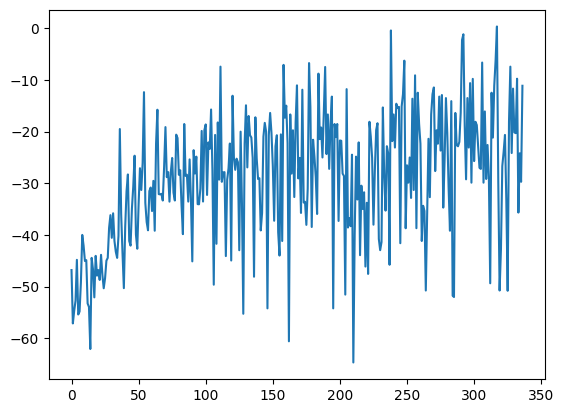

In [ ]:
import matplotlib.pyplot as plt
plt.plot(rewards)
plt.show()